In [ ]:
# !npm install --save lightweight-charts

In [ ]:
# pip install lightweight-charts
# https://github.com/louisnw01/lightweight-charts-python

In [ ]:
# pip install mplfinance
# pip install nbformat
# 

In [1]:
import yfinance as yf
import pandas as pd
# from lightweight_charts import Chart
import mplfinance as mpf

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [2]:
# 定义开始日期和股票代码
start_date = "2024-04-10"
ticker = "GC=F"

# 获取日线数据
daily_data = yf.download(ticker, start=start_date, interval="1d")

# 获取1小时线数据
hourly_1_data = yf.download(ticker, start=start_date, interval="1h")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# 定义计算列的函数
def calculate_columns(df):
    # 计算实体（开盘到收盘范围）
    df['Body'] = abs(df['Close'] - df['Open'])
    # 计算影线（当天最高和最低之间的范围）
    df['Wick'] = df['High'] - df['Low']
    # 实体和影线的总和
    df['Total'] = df['Body'] + df['Wick']
    # 判断K线是多头还是空头
    df['Bull/Bear'] = df.apply(lambda row: 'Bull' if row['Close'] > row['Open'] else 'Bear', axis=1)
    return df

# 计算每个区段的数据
daily_data = calculate_columns(daily_data)

hourly_1_data = calculate_columns(hourly_1_data)

# 输出结果
print("Daily Data:")
daily_data.head()

Daily Data:


,Open,High,Low,Close,Adj Close,Volume,Body,Wick,Total,Bull/Bear
Date,,,,,,,,,,
2024-04-10,2346.600098,2358.100098,2327.699951,2329.600098,2329.600098,377,17.000000,30.400146,47.400146,Bear
2024-04-11,2341.500000,2376.300049,2330.600098,2354.800049,2354.800049,283,13.300049,45.699951,59.000000,Bull
2024-04-12,2377.300049,2429.000000,2334.300049,2356.199951,2356.199951,584,21.100098,94.699951,115.800049,Bear
2024-04-15,2362.100098,2384.699951,2326.000000,2365.800049,2365.800049,1801,3.699951,58.699951,62.399902,Bull
2024-04-16,2384.000000,2390.800049,2371.399902,2390.800049,2390.800049,41,6.800049,19.400146,26.200195,Bull


In [4]:
Gold_daily_df = daily_data[['Open', 'High', 'Low', 'Close', 'Volume']]
Gold_daily_df.head()
Gold_daily_df.to_csv('/Users/gan-m2/Stock-Markets-Analytics/Src/yfinance_data/Gold_daily.csv')

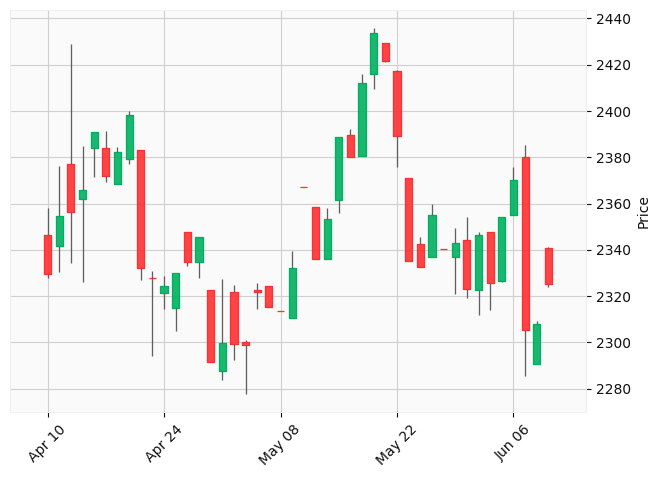

In [5]:
# https://github.com/matplotlib/mplfinance/blob/master/examples/marketcolor_overrides.ipynb
mpf.plot(Gold_daily_df,style='yahoo' ,type='candle')

### 分析在一定区域内的多空力量对比

In [6]:
from typing import Tuple


def analyze_candlestick_data(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
# def analyze_candlestick_data(data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """
    分析K线数据，按 'Bull/Bear' 分组，计算 'Body', 'Wick', 'Total' 的总和和平均值，并绘制图表。

    参数:
    data (pd.DataFrame): 包含K线数据的DataFrame，包含 'Body', 'Wick', 'Total' 和 'Bull/Bear' 列。

    返回:
    (pd.DataFrame, pd.DataFrame): 分别包含每组的总和和平均值的DataFrame。
    """
    # 按 'Bull/Bear' 分组并计算总和
    grouped_data_sum = data.groupby('Bull/Bear').sum()
    # 添加列 Bar_Count 显示每组的K线数量
    grouped_data_sum = grouped_data_sum.assign(Bar_Count=data['Bull/Bear'].value_counts())
    grouped_data_sum = grouped_data_sum[['Body', 'Wick', 'Total', 'Bar_Count']]

    # 按 'Bull/Bear' 分组并计算平均值
    grouped_data_mean = data.groupby('Bull/Bear').mean()
    # 添加列 Bar_Count 显示每组的K线数量
    grouped_data_mean = grouped_data_mean.assign(Bar_Count=data['Bull/Bear'].value_counts())
    grouped_data_mean = grouped_data_mean[['Body', 'Wick', 'Total', 'Bar_Count']]
    
    return grouped_data_sum, grouped_data_mean


In [7]:
grouped_data_sum, grouped_data_mean = analyze_candlestick_data(daily_data)

print(grouped_data_sum)

print("\n",grouped_data_mean)

                 Body        Wick        Total  Bar_Count
Bull/Bear                                                
Bear       427.400391  682.400146  1109.800537         24
Bull       321.499756  561.700439   883.200195         20

                 Body       Wick      Total  Bar_Count
Bull/Bear                                            
Bear       17.808350  28.433339  46.241689         24
Bull       16.074988  28.085022  44.160010         20


In [8]:
def plot_grouped_data_plotly(grouped_data: pd.DataFrame):
    """
    使用 Plotly 绘制按 'Bull/Bear' 分组计算的 'Body', 'Wick', 'Total' 的总和图表。

    参数:
    grouped_data (pd.DataFrame): 包含 'Body', 'Wick', 'Total' 和 'Bar_Count' 列的分组数据。

    返回:
    None
    """
    # 创建子图
    fig = make_subplots(rows=1, cols=3, subplot_titles=("Body", "Wick", "Total"))

    # 添加 Body 的总和图表
    fig.add_trace(
        go.Bar(name="Body", x=grouped_data.index, y=grouped_data['Body'], marker_color=['red', 'green']),
        row=1, col=1
    )

    # 添加 Wick 的总和图表
    fig.add_trace(
        go.Bar(name="Wick", x=grouped_data.index, y=grouped_data['Wick'], marker_color=['red', 'green']),
        row=1, col=2
    )

    # 添加 Total 的总和图表
    fig.add_trace(
        go.Bar(name="Total", x=grouped_data.index, y=grouped_data['Total'], marker_color=['red', 'green']),
        row=1, col=3
    )

    # 更新布局
    fig.update_layout(title_text="Grouped Data by Bull/Bear", showlegend=False)
    fig.update_xaxes(showticklabels=False)

    # 显示图表
    fig.show()

In [9]:
plot_grouped_data_plotly(grouped_data_sum)

In [10]:
plot_grouped_data_plotly(grouped_data_mean)

### 真实强弱指数 TSI (True Strength Index)

In [12]:
# pip install talipp

In [ ]:
# if __name__ == '__main__':
    
#     chart = Chart()
    
#     # Columns: time | open | high | low | close | volume 
#     df = pd.read_csv('/Users/gan-m2/Stock-Markets-Analytics/Src/yfinance_data/Gold_daily.csv')
#     chart.set(df)
    
#     chart.show(block=True)

In [70]:
import random
from talipp.ohlcv import OHLCVFactory


close = random.sample(range(1, 10000), 1000)
ohlcv = OHLCVFactory.from_matrix2([
        random.sample(range(1, 10000), 1000),
        random.sample(range(1, 10000), 1000),
        random.sample(range(1, 10000), 1000),
        random.sample(range(1, 10000), 1000),
        random.sample(range(1, 10000), 1000)]
    )

print(close[:5])

print(f"Last OHLCV: {ohlcv[-1]}")

from talipp.indicators import TSI, RSI

print(f'TSI: {TSI(13, 25, close)[-1]}')

print(f'RSI: {RSI(7, close)}')

[481, 6919, 5213, 6683, 568]
Last OHLCV: OHLCV(open=9803, high=4455, low=1324, close=916, volume=7393, time=None)
TSI: 1.0491542860356935
RSI: [None, None, None, None, None, None, None, 52.5453011370485, 56.98338604233311, 50.780665391252285, 49.32155317577095, 53.340883798581686, 59.825386795224674, 63.58836120043303, 69.37199802425707, 49.78674155430398, 42.576725956455185, 58.87154235006545, 45.44136436836618, 54.81812789698973, 45.221069083009304, 59.311929730976146, 55.528832844483894, 47.09255627242832, 43.453111334457446, 54.30153507802596, 53.28144132721902, 49.947536023744114, 56.90911037329815, 53.34618615430293, 44.22534096792, 40.842641255729326, 52.388785369971764, 60.48298109193795, 49.37041187956143, 50.484248466419864, 56.04783918319493, 52.44686951746688, 52.67254349256267, 53.49522948089856, 42.621423346365745, 34.10434810687363, 59.90262957443865, 45.73770767714523, 48.85509123544285, 45.02159909298437, 59.13107268877493, 47.567480322270406, 40.71178735835987, 48.989

In [40]:
TSI(13, 25, close)[-1]

1.6700494213591333

In [43]:
from talipp.indicators import TSI

daily_close = daily_data['Close']
# check type of close
# convert to list
daily_close = daily_close.tolist()

TSI_value = TSI(7, 15,daily_close)
TSI_value

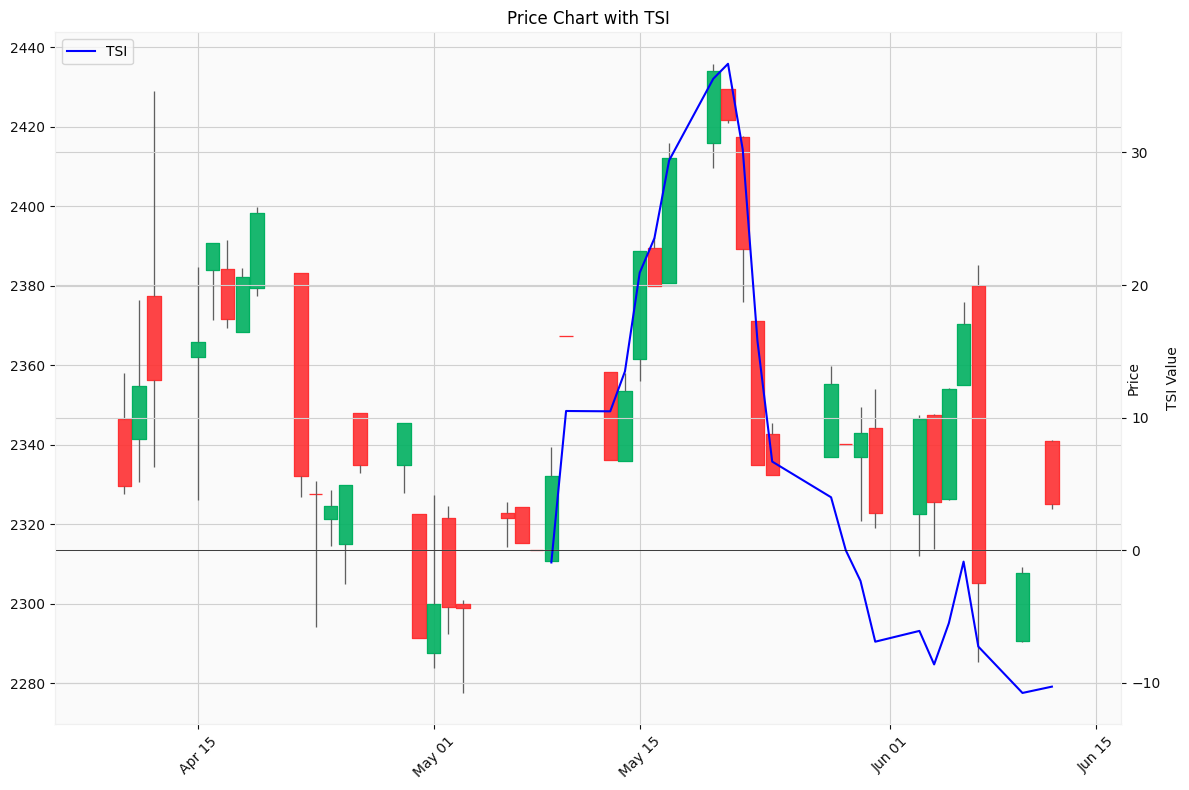

In [48]:
# 绘制烛台图和 TSI 指标在同一张图上
fig, ax1 = plt.subplots(figsize=(12, 8))

# 绘制烛台图
mpf.plot(daily_data, style='yahoo', type='candle', ax=ax1, volume=False, show_nontrading=True)
ax1.set_title('Price Chart with TSI')
ax1.set_ylabel('Price')

# 创建第二个 y 轴并绘制 TSI
ax2 = ax1.twinx()
ax2.plot(daily_data.index, daily_data['TSI'], label='TSI', color='blue')
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('TSI Value')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [66]:
from talipp.indicators import TSI

def find_missing_dates(data: pd.DataFrame) -> pd.DatetimeIndex:
    """
    找到从开始日期到结束日期之间缺失的日期。

    参数:
    data (pd.DataFrame): 包含日期索引的 DataFrame。

    返回:
    pd.DatetimeIndex: 缺失日期的索引。
    """
    # 获取开始日期和结束日期
    start_date = data.index.min()
    end_date = data.index.max()

    # 生成完整日期范围，包括所有日期
    full_range = pd.date_range(start=start_date, end=end_date, freq='D')  # freq='D' 表示每天

    # 找到缺失的日期
    missing_dates = full_range.difference(data.index)

    return missing_dates

# # 示例调用
# missing_dates = find_missing_dates(daily_data)
# print(missing_dates)

def plot_price_with_tsi(data: pd.DataFrame, EMA_short: int, EMA_long: int):
    """
    使用 Plotly 绘制价格和 TSI 指标图表。

    参数:
    data (pd.DataFrame): 包含 'Open', 'High', 'Low', 'Close' 列的价格数据。
    EMA_short (int): 短期EMA的周期,
    EMA_long (int): 长期EMA的周期。
    
    计算 TSI 值并将其添加到 DataFrame 中，然后绘制价格和 TSI 指标图表。[Link](https://www.investopedia.com/terms/t/tsi.asp)
    计算长短EMA，假设短周期为7，长周期为15，也就是说，我们需要计算7日EMA和15日EMA。[Link](https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp)

    Plotly图表包含烛台图和 TSI 线，TSI 线的值在右侧的第二个 y 轴上。
    
    TSI作用：识别超买和超卖信号，发现分歧，通过中心线识别趋势方向和变化，并通过信号线交叉突出显示短期价格动能
    """
    # 计算 TSI 值
    close_price = data['Close'].tolist()
    tsi = TSI(EMA_short, EMA_long, close_price)
    
    # 将 TSI 值添加到 DataFrame
    data['TSI'] = tsi

    # 绘制图表
    fig = go.Figure()

    # 添加烛台图
    fig.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ))

    # 添加 TSI 线
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data['TSI'],
        mode='lines',
        name='TSI',
        yaxis='y2',
        line=dict(color='blue')
    ))

    # 添加水平线表示 TSI 的 0 轴
    fig.add_trace(go.Scatter(
        x=data.index,
        y=[0] * len(data),
        mode='lines',
        name='Zero Line',
        yaxis='y2',
        line=dict(color='black', width=0.5, dash='dash')
    ))


    # 查找非交易日
    non_trading_days = find_missing_dates(daily_data)
    # print(missing_dates)
    # all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='B') # freq='B'表示工作日
    # non_trading_days = all_dates.difference(data.index)
    # print(non_trading_days)

    # 在非交易日绘制垂直线
    for non_trading_day in non_trading_days:
        fig.add_shape(
            dict(
                type="line",
                x0=non_trading_day,
                y0=0,
                x1=non_trading_day,
                y1=1,
                yref="paper",
                line=dict(
                    color="Red",
                    width=1
                )
            )
        )

    # 更新布局，只保留一种网格线
    fig.update_layout(
        title='Price Chart with TSI',
        xaxis_title='Date',
        yaxis_title='Price',
        yaxis2=dict(
            title='TSI Value',
            overlaying='y',
            side='right'
        ),
        xaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='LightGrey'
        ),
        yaxis=dict(
            showgrid=False
        ),
        legend=dict(
            x=0,
            y=1.2,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        )
    )

    # 显示图表
    fig.show()


# 调用函数绘制图表
plot_price_with_tsi(daily_data, 7, 15)

### 相对强弱指数 RSI (Relative Strength Index)

In [ ]:
import plotly.graph_objs as go
from talipp.indicators import RSI

In [99]:
def plot_price_with_rsi_embedding(data: pd.DataFrame, period: int, oversold_level: int = 30, overbought_level: int = 70):
    """
    使用 Plotly 绘制价格和 RSI 指标图表。

    参数:
    data (pd.DataFrame): 包含 'Open', 'High', 'Low', 'Close' 列的价格数据。
    period (int): RSI 的计算周期。

    返回:
    None
    """
    # 计算 RSI 值
    close_price = data['Close'].tolist()
    rsi = RSI(period, close_price)
    
    # 将 RSI 值添加到 DataFrame
    data['RSI'] = rsi

    # 绘制图表
    fig = go.Figure()

    # 添加烛台图
    fig.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ))

    # 添加 RSI 线
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data['RSI'],
        mode='lines',
        name='RSI',
        yaxis='y2',
        line=dict(color='blue')
    ))

    # 添加水平线表示 RSI 的 30 和 70 水平
    fig.add_trace(go.Scatter(
        x=data.index,
        y=[oversold_level] * len(data),  # Fixed the level to 30
        mode='lines',
        name='Oversold Line',
        yaxis='y2',
        line=dict(color='green', width=1.5, dash='dash') 
    ))

    fig.add_trace(go.Scatter(
        x=data.index,
        y=[overbought_level] * len(data),  # Fixed the level to 70
        mode='lines',
        name='Overbought Line',
        yaxis='y2',
        line=dict(color='red', width=1.5, dash='dash')
    ))

    # 查找非交易日
    non_trading_days = find_missing_dates(data)

    # 在非交易日绘制垂直线
    for non_trading_day in non_trading_days:
        fig.add_shape(
            dict(
                type="line",
                x0=non_trading_day,
                y0=0,  # Set to start from the bottom of the plot
                x1=non_trading_day,
                y1=1,
                yref="paper",
                line=dict(
                    color="Red",
                    width=1
                )
            )
        )
    
    fig.update_layout(
        title='Price Chart with RSI',
        xaxis_title='Date',
        yaxis_title='Price',
        yaxis2=dict(
            title='RSI Value',
            overlaying='y',
            side='right',
            range=[10, 90]  # Fixed Y-axis range for RSI
        ),
        
        xaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='LightGrey'
        ),
        yaxis=dict(
            showgrid=False
        ),
        xaxis2=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='LightGrey'
        ),
        # 调整图表的高度和宽度
        height=600,  
        width=1350,  
        margin=dict(l=50, r=50, t=50, b=50)
    )

    # 显示图表
    fig.show()

In [98]:
def plot_price_with_rsi_seperate(data: pd.DataFrame, period: int, oversold_level: int = 30, overbought_level: int = 70):
    """
    使用 Plotly 绘制价格和 RSI 指标图表。

    参数:
    data (pd.DataFrame): 包含 'Open', 'High', 'Low', 'Close' 列的价格数据。
    period (int): RSI 的计算周期。

    返回:
    None
    """
    # 计算 RSI 值
    close_price = data['Close'].tolist()
    rsi = RSI(period, close_price)
    data['RSI'] = rsi

    # 创建子图
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=('Price Chart', 'RSI'))

    # 添加烛台图
    fig.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ), row=1, col=1)

    # 添加 RSI 线
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data['RSI'],
        mode='lines',
        name='RSI',
        line=dict(color='blue')
    ), row=2, col=1)

    # 添加水平线表示超买和超卖区域
    fig.add_trace(go.Scatter(
        x=data.index,
        y=[45] * len(data),
        mode='lines',
        name='Oversold Line',
        line=dict(color='green', width=2, dash='dash')
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        x=data.index,
        y=[70] * len(data),
        mode='lines',
        name='Overbought Line',
        line=dict(color='red', width=2, dash='dash')
    ), row=2, col=1)

    # 查找非交易日
    non_trading_days = find_missing_dates(data)

    # 在每个图表上添加垂直线以表示非交易日
    for non_trading_day in non_trading_days:
        fig.add_shape(
            dict(
                type="line",
                x0=non_trading_day,
                y0=data['Low'].min(),
                x1=non_trading_day,
                y1=data['High'].max(),
                line=dict(
                    color="Red",
                    width=1
                )
            ),
            row=1, col=1
        )
        
        fig.add_shape(
            dict(
                type="line",
                x0=non_trading_day,
                y0=10,
                x1=non_trading_day,
                y1=90,
                line=dict(
                    color="Red",
                    width=1
                )
            ),
            row=2, col=1
        )

    # 更新布局
    fig.update_layout(
        title='Price Chart with RSI',
        xaxis=dict(
            rangeslider=dict(
                visible=False
            ),
            showticklabels=True,
            showgrid=True,
            gridwidth=1,
            gridcolor='LightGrey'
        ),
        xaxis2=dict(
            showticklabels=True,
            showgrid=True,
            gridwidth=1,
            gridcolor='LightGrey'
        ),
        yaxis=dict(
            title='Price',
            showgrid=False
        ),
        yaxis2=dict(
            title='RSI',
            range=[10, 90],
            showgrid=False
        ),
        height=800,
        margin=dict(l=50, r=50, t=50, b=50)
    )

    # 将时间轴放在底部
    fig.update_xaxes(rangeslider_visible=False, row=1, col=1)
    fig.update_xaxes(rangeslider_visible=True, row=2, col=1)

    # 显示图表
    fig.show()

In [100]:
# 调用函数绘制图表
def plot_price_with_rsi(data: pd.DataFrame, period: int, oversold_level: int = 45, overbought_level: int = 70, embedding: bool = True):
    """
    使用 Plotly 绘制价格和 RSI 指标图表。

    RSI (Relative Strength Index) 是一种动量振荡器，旨在衡量价格变动的速度和变化，用于识别超买和超卖条件。

    更多信息请参阅 [RSI](https://www.investopedia.com/terms/r/rsi.asp)

    参数:
    data (pd.DataFrame): 包含 'Open', 'High', 'Low', 'Close' 列的价格数据。
    period (int): 计算 RSI 的周期。
    oversold_level (int, optional): 设定的超卖水平线。默认值为 45。
    overbought_level (int, optional): 设定的超买水平线。默认值为 70。
    embedding (bool, optional): 决定是否将 RSI 嵌入在价格图表中。如果为 True，则嵌入。如果为 False，则单独绘制 RSI 图表。默认值为 True。

    返回:
    None
    """
    if embedding:
        plot_price_with_rsi_embedding(data, period, oversold_level, overbought_level)
    else:
        plot_price_with_rsi_seperate(data, period, oversold_level, overbought_level)

# 调用函数绘制图表
plot_price_with_rsi(daily_data, 14, embedding=True)